In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import h5py
from tqdm.auto import tqdm, trange
import scipy.io
import time
import torch
import random
import math
import shutil
from sklearn.decomposition import PCA
import scipy as sp
import scipy.signal
import os
import pandas as pd

from analysis.proj import learn_manifold_umap, pca_train, pca
from analysis.plotting import plot_all_pts, plot_contr_v_pca, plot_recon_v_spike, plot_spike_loc_classes
from analysis.contrastive_utils import get_enc_backbone, get_fcenc_backbone, get_ckpt_results
from analysis.cluster import GMM, HDBSCAN
from analysis.benchmarking import class_scores, avg_score, per_class_accs, avg_class_accs

from spike_psvae.denoise import SingleChanDenoiser

In [3]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

## Load Data

In [4]:
import MEArec as mr
data_base_dir = Path('/moto/stats/users/ch3676/datasets_contrastive_ephys/')
data_type = Path('single_channel/DY016_random_neurons/')
data_name = Path('dy016_random_neurons_04_28_2023')
data_path = data_base_dir / data_type / data_name

In [5]:
unit_ids = np.load(data_path / 'unit_ids.npy')
spikes_train = np.load(data_path / 'spikes_train.npy')
spikes_test = np.load(data_path / 'spikes_test.npy')
labels_test = np.load(data_path / 'labels_test.npy')
labels_train = np.load(data_path / 'labels_train.npy')
selected_units = np.load(data_path / 'selected_units.npy')

## Set PCA params

In [6]:
if len(spikes_train.shape) == 2:
    print("single channel waveforms")
    num_chan_pca = 1
else:
    print("multi-chanel waveforms")
    num_chan_pca = 3

single channel waveforms


## Denoise

In [7]:
denoised_wfs_train = []
denoised_wfs_test = []

wfs_train = spikes_train.copy()
wfs_test = spikes_test.copy()

denoiser = SingleChanDenoiser()
denoiser.load('/moto/home/ch3676/spike-psvae/pretrained/single_chan_denoiser.pt')

for i in range(len(wfs_train)):
    curr_wf = wfs_train[i]
    with torch.no_grad():
        curr_wf = torch.unsqueeze(torch.from_numpy(curr_wf), dim=0)
        den_wf = denoiser(curr_wf)
        denoised_wfs_train.append(den_wf.squeeze().numpy())

denoised_wfs_train = np.array(denoised_wfs_train)
    
for i in range(len(wfs_test)):
    curr_wf = wfs_test[i]
    with torch.no_grad():
        curr_wf = torch.unsqueeze(torch.from_numpy(curr_wf), dim=0)
        den_wf = denoiser(curr_wf)
        denoised_wfs_test.append(den_wf.squeeze().numpy())

In [10]:
wfs_train_mean = np.mean(np.array([wf.flatten() for wf in wfs_train]), axis=0)
wfs_train_norm = np.array([wf.flatten() for wf in wfs_train]) - wfs_train_mean
wfs_test_norm = np.array([wf.flatten() for wf in wfs_test]) - wfs_train_mean

denoised_wfs_train_mean = np.mean(np.array([wf.flatten() for wf in denoised_wfs_train]), axis=0)
denoised_wfs_train_norm = np.array([wf.flatten() for wf in denoised_wfs_train]) - denoised_wfs_train_mean
denoised_wfs_test_norm = np.array([wf.flatten() for wf in denoised_wfs_test]) - denoised_wfs_train_mean


n_comps = 10
std_scale = 1
pcs_train, _, _ = pca(wfs_train_norm, n_comps) * std_scale
pcs_test, pcs_ex_var  = pca_train(wfs_train_norm, wfs_test_norm, n_comps) * std_scale
denoised_pcs_train, _, _  = pca(denoised_wfs_train_norm, n_comps) * std_scale
denoised_pcs_test, denoised_pcs_ex_var = pca_train(denoised_wfs_train_norm, denoised_wfs_test_norm, n_comps) * std_scale

train done
pca test done
train done
pca test done


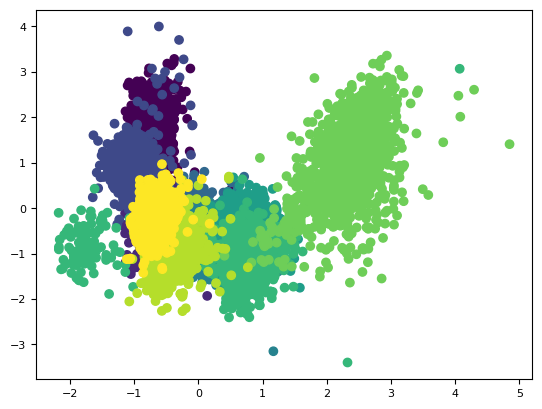

In [11]:
plt.scatter(denoised_pcs_train[:,0], denoised_pcs_train[:,1], c=labels_train);

In [45]:
from sklearn.mixture import GaussianMixture
import hdbscan
import numpy as np
from sklearn.metrics import adjusted_rand_score

# covariance_type : {'full', 'tied', 'diag', 'spherical'}
# reps_train = pcs_train
# reps_test = pcs_test
covariance_type = 'full'
n_clusters = 10
reps_train = denoised_pcs_train
reps_test = denoised_pcs_test
gmm_list = []
num_components = np.arange(2, pcs_train.shape[1]+1)
for num_c in num_components:
    gmm = GaussianMixture(n_clusters, 
                          random_state=0, 
                          covariance_type=covariance_type).fit(reps_train[:,:num_c])
    gmm_list.append(gmm)
    test_labels = gmm.predict(reps_test[:,:num_c])
    score = adjusted_rand_score(labels_test, test_labels)*100
    print(f"num_comps: {num_c}, rand_score: {score}")

num_comps: 2, rand_score: 48.5897287951864
num_comps: 3, rand_score: 50.570854241037054
num_comps: 4, rand_score: 42.83296291141328
num_comps: 5, rand_score: 64.67296741475278
num_comps: 6, rand_score: 58.693680733332286
num_comps: 7, rand_score: 58.27907805620871
num_comps: 8, rand_score: 49.49739819812514
num_comps: 9, rand_score: 60.245695658126685
num_comps: 10, rand_score: 60.27971298873239


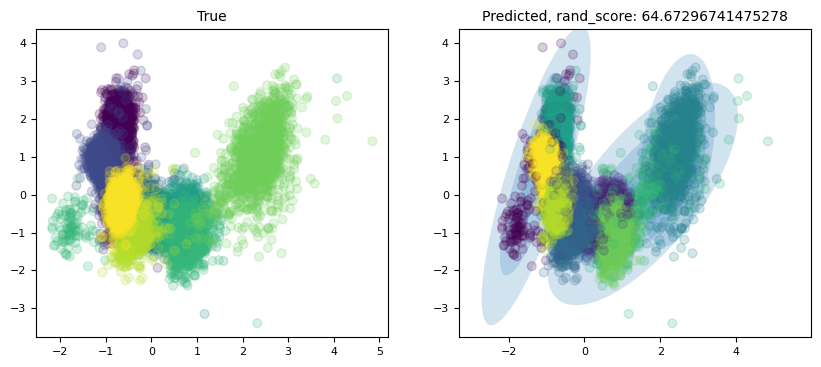

In [46]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
model_id = 3
X = reps_train[:,:num_components[model_id]]
gmm = gmm_list[model_id]
axes[0].scatter(X[:, 0], X[:, 1], c=labels_train, s=40, cmap='viridis', zorder=2, alpha=.2)
plot_gmm(gmm, X, label=True, ax=axes[1])
test_labels = gmm.predict(reps_test[:,:num_components[model_id]])
score = adjusted_rand_score(labels_test, test_labels)*100
axes[0].set_title('True')
axes[1].set_title(f'Predicted, rand_score: {score}');

In [17]:
from models.model_GPT import GPT, GPTConfig

In [18]:
#change params based on checkpoint
GPTConfig.out_dim = 5
GPTConfig.proj_dim = 5 
GPTConfig.n_embd = 32
GPTConfig.n_head = 4
GPTConfig.block_size = 121
GPTConfig.bias = False
GPTConfig.n_layer = 20
GPTConfig.is_causal = True

#choose model class
model = GPT(GPTConfig)

#load checkpoint
path_to_checkpoint = Path('/moto/stats/users/ch3676/spike_contrastive_models_0501/0501out_dim5proj_dim5batch-size512lr0.001epochs800fp16use_gptis_causaln_embd32')
checkpoint_path = path_to_checkpoint / 'checkpoint.pth'
checkpoint = torch.load(checkpoint_path, map_location="cpu")
state_dict = checkpoint["state_dict"]
sd_keys = state_dict.keys()
state_dict_final = {k:state_dict[k] for k in sd_keys if not k.endswith('.attn.bias')}
model.load_state_dict(state_dict_final)

Using projector; batchnorm False with depth 3; hidden_dim=512
number of parameters: 0.52M


<All keys matched successfully>

In [19]:
wfs_train_torch = torch.from_numpy(wfs_train[:,:,None])
wfs_train_cont = model.forward(wfs_train_torch)
wfs_train_cont_numpy = wfs_train_cont.detach().numpy()
del wfs_train_cont

wfs_test_torch = torch.from_numpy(wfs_test[:,:,None])
wfs_test_cont = model.forward(wfs_test_torch)
wfs_test_cont_numpy = wfs_test_cont.detach().numpy()
del wfs_test_cont

In [52]:
from sklearn.mixture import GaussianMixture
import hdbscan
import numpy as np
from sklearn.metrics import adjusted_rand_score

# covariance_type : {'full', 'tied', 'diag', 'spherical'}
# reps_train = pcs_train
# reps_test = pcs_test
covariance_type = 'full'
n_clusters = 10
reps_train = wfs_train_cont_numpy
reps_test = wfs_test_cont_numpy
gmm_list_cont = []
num_components = np.arange(5, reps_train.shape[1]+1)
for num_c in num_components:
    gmm = GaussianMixture(n_clusters, 
                          random_state=0, 
                          covariance_type=covariance_type).fit(reps_train[:,:num_c])
    gmm_list_cont.append(gmm)
    test_labels = gmm.predict(reps_test[:,:num_c])
    score = adjusted_rand_score(labels_test, test_labels)*100
    print(f"num_comps: {num_c}, rand_score: {score}")

num_comps: 5, rand_score: 86.59857684146249


In [81]:
pcs_train_cont, _, _ = pca(wfs_train_cont_numpy, n_comps=2)
pcs_test_cont, pcs_ex_var  = pca_train(wfs_train_cont_numpy, wfs_test_cont_numpy, n_comps=2)

train done
pca test done


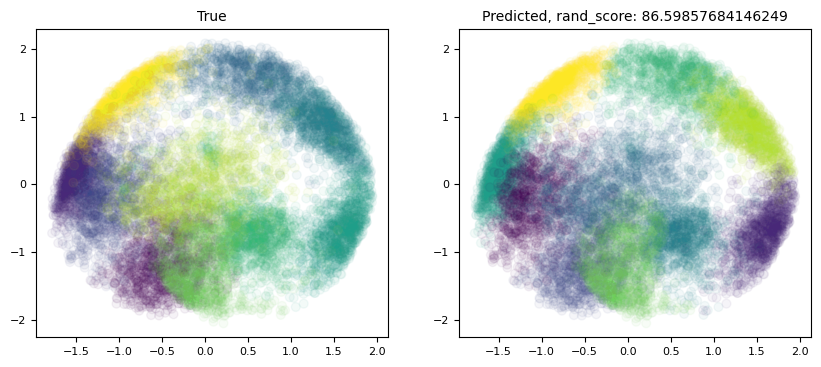

In [112]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
X = pcs_train_cont
gmm = gmm_list_cont[0]
train_labels = gmm.predict(wfs_train_cont_numpy)
axes[0].scatter(X[:, 0], X[:, 1], c=labels_train, s=40, cmap='viridis', zorder=2, alpha=.05)
axes[1].scatter(X[:, 0], X[:, 1], c=train_labels, s=40, cmap='viridis', zorder=2, alpha=.05)
# plot_gmm(gmm, wfs_train_cont_numpy, label=True, ax=axes[1])
test_labels = gmm.predict(wfs_test_cont_numpy)
score = adjusted_rand_score(labels_test, test_labels)*100
axes[0].set_title('True')
axes[1].set_title(f'Predicted, rand_score: {score}');

In [108]:
"""Mean shift clustering algorithm.

Mean shift clustering aims to discover *blobs* in a smooth density of
samples. It is a centroid based algorithm, which works by updating candidates
for centroids to be the mean of the points within a given region. These
candidates are then filtered in a post-processing stage to eliminate
near-duplicates to form the final set of centroids.

Seeding is performed using a binning technique for scalability.
"""

# Authors: Conrad Lee <conradlee@gmail.com>
#          Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Gael Varoquaux <gael.varoquaux@normalesup.org>
#          Martino Sorbaro <martino.sorbaro@ed.ac.uk>

import numpy as np
import warnings

from collections import defaultdict
import six
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_random_state, gen_batches, check_array
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances_argmin
from joblib import Parallel
from joblib import delayed
from joblib import effective_n_jobs

def estimate_bandwidth(X, quantile=0.3, n_samples=None, random_state=0,
                       n_jobs=None):
    """Estimate the bandwidth to use with the mean-shift algorithm.

    That this function takes time at least quadratic in n_samples. For large
    datasets, it's wise to set that parameter to a small value.

    Parameters
    ----------
    X : array-like, shape=[n_samples, n_features]
        Input points.

    quantile : float, default 0.3
        should be between [0, 1]
        0.5 means that the median of all pairwise distances is used.

    n_samples : int, optional
        The number of samples to use. If not given, all samples are used.

    random_state : int, RandomState instance or None (default)
        The generator used to randomly select the samples from input points
        for bandwidth estimation. Use an int to make the randomness
        deterministic.
        See :term:`Glossary <random_state>`.

    n_jobs : int or None, optional (default=None)
        The number of parallel jobs to run for neighbors search.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    Returns
    -------
    bandwidth : float
        The bandwidth parameter.
    """
    X = check_array(X)

    random_state = check_random_state(random_state)
    if n_samples is not None:
        idx = random_state.permutation(X.shape[0])[:n_samples]
        X = X[idx]
    n_neighbors = int(X.shape[0] * quantile)
    if n_neighbors < 1:  # cannot fit NearestNeighbors with n_neighbors = 0
        n_neighbors = 1
    nbrs = NearestNeighbors(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
    nbrs.fit(X)

    bandwidth = 0.
    for batch in gen_batches(len(X), 500):
        d, _ = nbrs.kneighbors(X[batch, :], return_distance=True)
        bandwidth += np.max(d, axis=1).sum()

    return bandwidth / X.shape[0]


# separate function for each seed's iterative loop
def _mean_shift_single_seed(my_mean, X, nbrs, max_iter):
    # For each seed, climb gradient until convergence or max_iter
    bandwidth = nbrs.get_params()['radius']
    stop_thresh = 1e-3 * bandwidth  # when mean has converged
    completed_iterations = 0
    while True:
        # Find mean of points within bandwidth
        i_nbrs = nbrs.radius_neighbors([my_mean], bandwidth,
                                       return_distance=False)[0]
        points_within = X[i_nbrs]
        if len(points_within) == 0:
            break  # Depending on seeding strategy this condition may occur
        my_old_mean = my_mean  # save the old mean
        my_mean = np.mean(points_within, axis=0)
        # If converged or at max_iter, adds the cluster
        if (np.linalg.norm(my_mean - my_old_mean) < stop_thresh or
                completed_iterations == max_iter):
            return tuple(my_mean), len(points_within)
        completed_iterations += 1


def _mean_shift_multi_seeds(my_means, X, nbrs, max_iter):
    # Process a batch of seeds.
    res = []
    for my_mean in my_means:
        res.append(_mean_shift_single_seed(my_mean, X, nbrs, max_iter))
    return res


def mean_shift(X, bandwidth=None, seeds=None, bin_seeding=False,
               min_bin_freq=1, cluster_all=True, max_iter=300,
               n_jobs=None):
    """Perform mean shift clustering of data using a flat kernel.

    Read more in the :ref:`User Guide <mean_shift>`.

    Parameters
    ----------

    X : array-like, shape=[n_samples, n_features]
        Input data.

    bandwidth : float, optional
        Kernel bandwidth.

        If bandwidth is not given, it is determined using a heuristic based on
        the median of all pairwise distances. This will take quadratic time in
        the number of samples. The sklearn.cluster.estimate_bandwidth function
        can be used to do this more efficiently.

    seeds : array-like, shape=[n_seeds, n_features] or None
        Point used as initial kernel locations. If None and bin_seeding=False,
        each data point is used as a seed. If None and bin_seeding=True,
        see bin_seeding.

    bin_seeding : boolean, default=False
        If true, initial kernel locations are not locations of all
        points, but rather the location of the discretized version of
        points, where points are binned onto a grid whose coarseness
        corresponds to the bandwidth. Setting this option to True will speed
        up the algorithm because fewer seeds will be initialized.
        Ignored if seeds argument is not None.

    min_bin_freq : int, default=1
       To speed up the algorithm, accept only those bins with at least
       min_bin_freq points as seeds.

    cluster_all : boolean, default True
        If true, then all points are clustered, even those orphans that are
        not within any kernel. Orphans are assigned to the nearest kernel.
        If false, then orphans are given cluster label -1.

    max_iter : int, default 300
        Maximum number of iterations, per seed point before the clustering
        operation terminates (for that seed point), if has not converged yet.

    n_jobs : int or None, optional (default=None)
        The number of jobs to use for the computation. This works by computing
        each of the n_init runs in parallel.

        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

        .. versionadded:: 0.17
           Parallel Execution using *n_jobs*.

    Returns
    -------

    cluster_centers : array, shape=[n_clusters, n_features]
        Coordinates of cluster centers.

    labels : array, shape=[n_samples]
        Cluster labels for each point.

    Notes
    -----
    For an example, see :ref:`examples/cluster/plot_mean_shift.py
    <sphx_glr_auto_examples_cluster_plot_mean_shift.py>`.

    """

    if bandwidth is None:
        bandwidth = estimate_bandwidth(X, n_jobs=n_jobs)
    elif bandwidth <= 0:
        raise ValueError("bandwidth needs to be greater than zero or None,\
            got %f" % bandwidth)
    if seeds is None:
        if bin_seeding:
            seeds = get_bin_seeds(X, bandwidth, min_bin_freq)
        else:
            seeds = X
    n_samples, n_features = X.shape
    center_intensity_dict = {}

    # We use n_jobs=1 because this will be used in nested calls under
    # parallel calls to _mean_shift_single_seed so there is no need for
    # for further parallelism.
    nbrs = NearestNeighbors(radius=bandwidth, n_jobs=1).fit(X)

    ncpus = effective_n_jobs(n_jobs)
    nseeds = int(len(seeds)//ncpus+1)
    print("number of seeds: "+str(len(seeds)))
    print("seeds/job: "+str(nseeds))
    print("using "+str(ncpus)+" cpus")

    # here each job gets its batch of seeds:
    all_res = Parallel(n_jobs=ncpus, max_nbytes=1e6, verbose=2)(
        delayed(_mean_shift_multi_seeds)
        (seeds[i*nseeds:(i+1)*nseeds], X, nbrs, max_iter) for i in range(ncpus))

    # retrieve results from batches
    for i in range(ncpus):
        for ii in range(len(all_res[i])):
            if all_res[i][ii] is not None:
                center_intensity_dict[all_res[i][ii][0]] = all_res[i][ii][1]

    if not center_intensity_dict:
        # nothing near seeds
        raise ValueError("No point was within bandwidth=%f of any seed."
                         " Try a different seeding strategy \
                         or increase the bandwidth."
                         % bandwidth)

    # POST PROCESSING: remove near duplicate points
    # If the distance between two kernels is less than the bandwidth,
    # then we have to remove one because it is a duplicate. Remove the
    # one with fewer points.
    sorted_by_intensity = sorted(center_intensity_dict.items(),
                                 key=lambda tup: (tup[1], tup[0]),
                                 reverse=True)
    sorted_centers = np.array([tup[0] for tup in sorted_by_intensity])
    unique = np.ones(len(sorted_centers), dtype=np.bool)
    nbrs = NearestNeighbors(radius=bandwidth,
                            n_jobs=1).fit(sorted_centers)
    for i, center in enumerate(sorted_centers):
        if unique[i]:
            neighbor_idxs = nbrs.radius_neighbors([center],
                                                  return_distance=False)[0]
            unique[neighbor_idxs] = 0
            unique[i] = 1  # leave the current point as unique
    cluster_centers = sorted_centers[unique]

    # ASSIGN LABELS: a point belongs to the cluster that it is closest to
    nbrs = NearestNeighbors(n_neighbors=1, n_jobs=1).fit(cluster_centers)
    labels = np.zeros(n_samples, dtype=np.int)
    distances, idxs = nbrs.kneighbors(X)
    if cluster_all:
        labels = idxs.flatten()
    else:
        labels.fill(-1)
        bool_selector = distances.flatten() <= bandwidth
        labels[bool_selector] = idxs.flatten()[bool_selector]
    return cluster_centers, labels


def get_bin_seeds(X, bin_size, min_bin_freq=1):
    """Finds seeds for mean_shift.

    Finds seeds by first binning data onto a grid whose lines are
    spaced bin_size apart, and then choosing those bins with at least
    min_bin_freq points.

    Parameters
    ----------

    X : array-like, shape=[n_samples, n_features]
        Input points, the same points that will be used in mean_shift.

    bin_size : float
        Controls the coarseness of the binning. Smaller values lead
        to more seeding (which is computationally more expensive). If you're
        not sure how to set this, set it to the value of the bandwidth used
        in clustering.mean_shift.

    min_bin_freq : integer, optional
        Only bins with at least min_bin_freq will be selected as seeds.
        Raising this value decreases the number of seeds found, which
        makes mean_shift computationally cheaper.

    Returns
    -------
    bin_seeds : array-like, shape=[n_samples, n_features]
        Points used as initial kernel positions in clustering.mean_shift.
    """

    # Bin points
    bin_sizes = defaultdict(int)
    for point in X:
        binned_point = np.round(point / bin_size)
        bin_sizes[tuple(binned_point)] += 1

    # Select only those bins as seeds which have enough members
    bin_seeds = np.array([point for point, freq in six.iteritems(bin_sizes) if
                          freq >= min_bin_freq], dtype=np.float32)
    if len(bin_seeds) == len(X):
        warnings.warn("Binning data failed with provided bin_size=%f,"
                      " using data points as seeds." % bin_size)
        return X
    bin_seeds = bin_seeds * bin_size
    return bin_seeds


class MeanShift(BaseEstimator, ClusterMixin):
    """Mean shift clustering using a flat kernel.

    Mean shift clustering aims to discover "blobs" in a smooth density of
    samples. It is a centroid-based algorithm, which works by updating
    candidates for centroids to be the mean of the points within a given
    region. These candidates are then filtered in a post-processing stage to
    eliminate near-duplicates to form the final set of centroids.

    Seeding is performed using a binning technique for scalability.

    Read more in the :ref:`User Guide <mean_shift>`.

    Parameters
    ----------
    bandwidth : float, optional
        Bandwidth used in the RBF kernel.

        If not given, the bandwidth is estimated using
        sklearn.cluster.estimate_bandwidth; see the documentation for that
        function for hints on scalability (see also the Notes, below).

    seeds : array, shape=[n_samples, n_features], optional
        Seeds used to initialize kernels. If not set,
        the seeds are calculated by clustering.get_bin_seeds
        with bandwidth as the grid size and default values for
        other parameters.

    bin_seeding : boolean, optional
        If true, initial kernel locations are not locations of all
        points, but rather the location of the discretized version of
        points, where points are binned onto a grid whose coarseness
        corresponds to the bandwidth. Setting this option to True will speed
        up the algorithm because fewer seeds will be initialized.
        default value: False
        Ignored if seeds argument is not None.

    min_bin_freq : int, optional
       To speed up the algorithm, accept only those bins with at least
       min_bin_freq points as seeds. If not defined, set to 1.

    cluster_all : boolean, default True
        If true, then all points are clustered, even those orphans that are
        not within any kernel. Orphans are assigned to the nearest kernel.
        If false, then orphans are given cluster label -1.

    n_jobs : int or None, optional (default=None)
        The number of jobs to use for the computation. This works by computing
        each of the n_init runs in parallel.

        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    Attributes
    ----------
    cluster_centers_ : array, [n_clusters, n_features]
        Coordinates of cluster centers.

    labels_ :
        Labels of each point.

    Examples
    --------
    >>> from sklearn.cluster import MeanShift
    >>> import numpy as np
    >>> X = np.array([[1, 1], [2, 1], [1, 0],
    ...               [4, 7], [3, 5], [3, 6]])
    >>> clustering = MeanShift(bandwidth=2).fit(X)
    >>> clustering.labels_
    array([1, 1, 1, 0, 0, 0])
    >>> clustering.predict([[0, 0], [5, 5]])
    array([1, 0])
    >>> clustering # doctest: +NORMALIZE_WHITESPACE
    MeanShift(bandwidth=2, bin_seeding=False, cluster_all=True, min_bin_freq=1,
         n_jobs=None, seeds=None)

    Notes
    -----

    Scalability:

    Because this implementation uses a flat kernel and
    a Ball Tree to look up members of each kernel, the complexity will tend
    towards O(T*n*log(n)) in lower dimensions, with n the number of samples
    and T the number of points. In higher dimensions the complexity will
    tend towards O(T*n^2).

    Scalability can be boosted by using fewer seeds, for example by using
    a higher value of min_bin_freq in the get_bin_seeds function.

    Note that the estimate_bandwidth function is much less scalable than the
    mean shift algorithm and will be the bottleneck if it is used.

    References
    ----------

    Dorin Comaniciu and Peter Meer, "Mean Shift: A robust approach toward
    feature space analysis". IEEE Transactions on Pattern Analysis and
    Machine Intelligence. 2002. pp. 603-619.

    """
    def __init__(self, bandwidth=None, seeds=None, bin_seeding=False,
                 min_bin_freq=1, cluster_all=True, n_jobs=None):
        self.bandwidth = bandwidth
        self.seeds = seeds
        self.bin_seeding = bin_seeding
        self.cluster_all = cluster_all
        self.min_bin_freq = min_bin_freq
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        """Perform clustering.

        Parameters
        -----------
        X : array-like, shape=[n_samples, n_features]
            Samples to cluster.

        y : Ignored

        """
        X = check_array(X)
        self.cluster_centers_, self.labels_ = \
            mean_shift(X, bandwidth=self.bandwidth, seeds=self.seeds,
                       min_bin_freq=self.min_bin_freq,
                       bin_seeding=self.bin_seeding,
                       cluster_all=self.cluster_all, n_jobs=self.n_jobs)
        return self

    def predict(self, X):
        """Predict the closest cluster each sample in X belongs to.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape=[n_samples, n_features]
            New data to predict.

        Returns
        -------
        labels : array, shape [n_samples,]
            Index of the cluster each sample belongs to.
        """
        check_is_fitted(self, "cluster_centers_")
        print('predicting')

        return pairwise_distances_argmin(X, self.cluster_centers_)

In [110]:
clustering = MeanShift(bandwidth=2, n_jobs=20).fit(wfs_test_cont_numpy)
labels_test_ms = clustering.predict(wfs_test_cont_numpy)
score = adjusted_rand_score(labels_test, labels_test_ms)*100

number of seeds: 3000
seeds/job: 151
using 20 cpus


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   25.6s remaining:  2.4min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   29.2s remaining:   12.5s


predicting


[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   30.3s finished


In [136]:
score = adjusted_rand_score(labels_test, labels_test_ms)*100

In [130]:
learn_manifold_umap(data, umap_dim, umap_min_dist=0.2, umap_metric='euclidean', umap_neighbors=10)

<function analysis.proj.learn_manifold_umap(data, umap_dim, umap_min_dist=0.2, umap_metric='euclidean', umap_neighbors=10)>

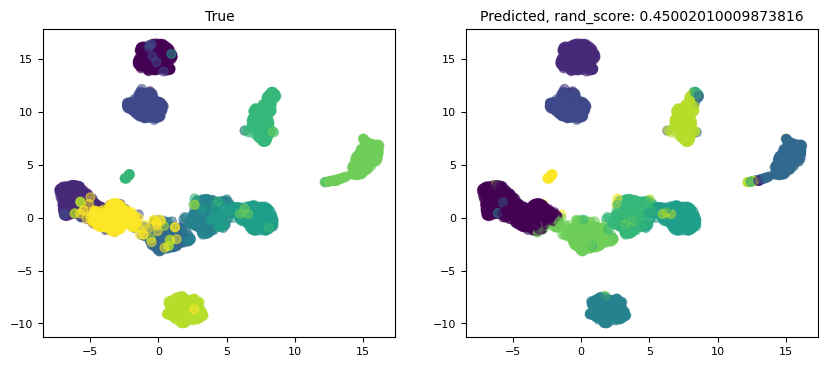

In [132]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
X = learn_manifold_umap(wfs_test_cont_numpy, umap_dim=2, umap_min_dist=0.2, umap_metric='euclidean', umap_neighbors=10)

In [151]:
X = learn_manifold_umap(wfs_test_cont_numpy, umap_dim=2, umap_min_dist=0.2, umap_metric='euclidean', umap_neighbors=10)
clustering = MeanShift(bandwidth=2, n_jobs=20).fit(X)
labels_test_ms = clustering.predict(X)
score = adjusted_rand_score(labels_test, labels_test_ms)*100

number of seeds: 3000
seeds/job: 151
using 20 cpus


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   20.9s remaining:  2.0min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   22.8s remaining:    9.8s


predicting


[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   23.1s finished


In [154]:
np.unique(labels_test_ms)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [152]:
# X = learn_manifold_umap(wfs_train_cont_numpy, umap_dim=2, umap_min_dist=0.2, umap_metric='euclidean', umap_neighbors=10)
# clustering = MeanShift(bandwidth=2, n_jobs=20).fit(X)
# labels_train_ms = clustering.predict(X)
# score = adjusted_rand_score(labels_train, labels_train_ms)*100

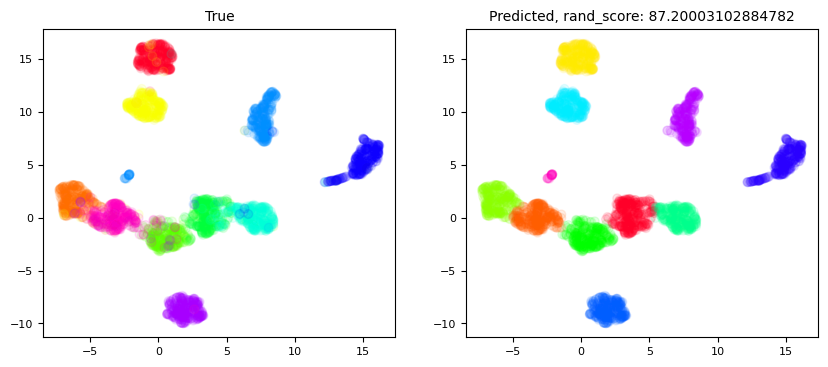

In [153]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
axes[1].scatter(X[:, 0], X[:, 1], c=labels_test_ms, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
# plot_gmm(gmm, wfs_train_cont_numpy, label=True, ax=axes[1])
axes[0].set_title('True')
axes[1].set_title(f'Predicted, rand_score: {score}');

In [143]:
X = learn_manifold_umap(pcs_test, umap_dim=2, umap_min_dist=0.2, umap_metric='euclidean', umap_neighbors=10)
clustering = MeanShift(bandwidth=2, n_jobs=20).fit(X)
labels_test_ms_pcs = clustering.predict(X)
score = adjusted_rand_score(labels_test, labels_test_ms_pcs)*100

number of seeds: 3000
seeds/job: 151
using 20 cpus


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   22.0s remaining:  2.1min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   38.0s remaining:   16.3s


predicting


[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   49.0s finished


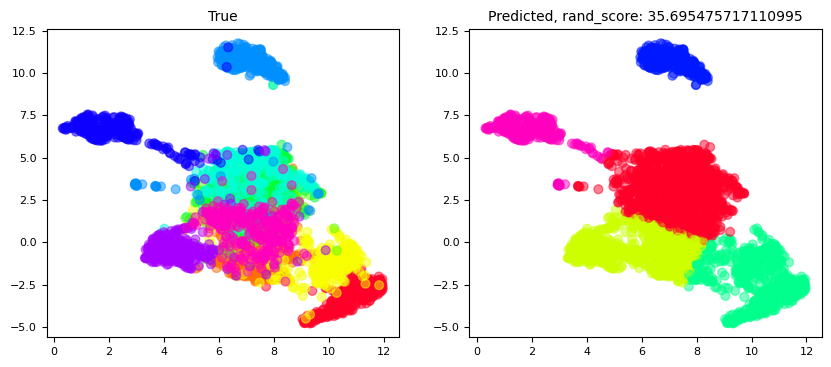

In [148]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
# X = pcs_test
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.5)
axes[1].scatter(X[:, 0], X[:, 1], c=labels_test_ms_pcs, s=40, cmap='gist_rainbow', zorder=2, alpha=.5)
# plot_gmm(gmm, wfs_train_cont_numpy, label=True, ax=axes[1])
axes[0].set_title('True')
axes[1].set_title(f'Predicted, rand_score: {score}');

In [14]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, alpha=.2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2, alpha=.2)
    ax.axis('equal')
    
    w_factor = .2
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos[:2], covar[:2,:2], alpha=w_factor)

In [ ]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [71]:
reps_train = pcs_train
reps_test = pcs_test
for num_c in np.arange(2, denoised_pcs_train.shape[1]+1):
    gm = GaussianMixture(model_params['n_clusters'], 
                         random_state=0, 
                         covariance_type='full').fit(reps_train[:,:num_c])
    test_labels = gm.predict(reps_test[:,:num_c])
    score = adjusted_rand_score(labels_test, test_labels)*100
    print(f"num_comps: {num_c}, rand_score: {score}")

num_comps: 2, rand_score: 51.86089914696319
num_comps: 3, rand_score: 63.42369848143862
num_comps: 4, rand_score: 61.88944653728431
num_comps: 5, rand_score: 58.36880180978419
num_comps: 6, rand_score: 61.341115386493314
num_comps: 7, rand_score: 59.03326543900942
num_comps: 8, rand_score: 62.923237345998196
num_comps: 9, rand_score: 67.13956997337473
num_comps: 10, rand_score: 62.07962982569985
num_comps: 11, rand_score: 62.819179954212466
num_comps: 12, rand_score: 62.81706257288556
num_comps: 13, rand_score: 49.943828257211145
num_comps: 14, rand_score: 52.65677649300443
num_comps: 15, rand_score: 68.90455785792355
num_comps: 16, rand_score: 61.60542468764141
num_comps: 17, rand_score: 69.48138484846874
num_comps: 18, rand_score: 67.33510820397154
num_comps: 19, rand_score: 58.4900380008338
num_comps: 20, rand_score: 59.51118907547117


In [47]:
train_list = [pcs_train[:,:2], denoised_pcs_train[:,:2], pcs_train[:,:5], denoised_pcs_train[:,:5]]
test_list = [pcs_test[:,:2], denoised_pcs_test[:,:2], pcs_test[:,:5], denoised_pcs_test[:,:5]]

cluster_method = 'GMM'
models = [f'{cluster_method} Single-chan, num pcs: {train_list[0].shape[1]}', 
          f'{cluster_method} Denoised single-chan, num pcs: {train_list[1].shape[1]}',
          f'{cluster_method} Single-chan, num pcs: {train_list[2].shape[1]}',
          f'{cluster_method} Denoised single-chan, num pcs: {train_list[3].shape[1]}'] 

num_classes = len(np.unique(labels_test))
model_params = {'n_clusters':15, 'min_cluster_size':20}
per_class_map = per_class_accs(train_list, test_list, models, num_classes, cluster_method.lower(), unit_ids, model_params)
avg_class_map = avg_class_accs(train_list, test_list, models, num_classes, cluster_method.lower(), model_params)

pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)

wf 8  wf 9  wf 11  wf 13  wf 23  wf 24   
GMM Single-chan, num pcs: 2            0.0   0.0    0.0    0.0    0.0    0.0  \
GMM Denoised single-chan, num pcs: 2   0.0   0.0    0.0    0.0    0.0    0.0   
GMM Single-chan, num pcs: 5            0.0   0.0    0.0    0.0    0.0    0.0   
GMM Denoised single-chan, num pcs: 5   0.0   0.0    0.0    0.0    0.0    0.0   

                                      wf 29  wf 30  wf 31  wf 32  
GMM Single-chan, num pcs: 2             0.0    0.0    0.0    0.0  
GMM Denoised single-chan, num pcs: 2    0.0    0.0    0.0    0.0  
GMM Single-chan, num pcs: 5             0.0    0.0    0.0    0.0  
GMM Denoised single-chan, num pcs: 5    0.0    0.0    0.0    0.0

GMM Single-chan, num pcs: 2  GMM Denoised single-chan, num pcs: 2   
score                    51.860899                             40.873502  \

       GMM Single-chan, num pcs: 5  GMM Denoised single-chan, num pcs: 5  
score                    60.785662                             48.298136

In [ ]:
mearec_denoised_wfs_train_locs.std(0).mean()

In [ ]:
mearec_exp_var = pca(np.array([mc.flatten() for mc in mearec_wfs_train]), 4)[1]
print(mearec_exp_var)
print(np.sum(mearec_exp_var))

Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.


wf 8       wf 9      wf 11  \
PCA 2D                                            100.0  99.333333  62.666667   
PCA 3D                                            100.0  98.666667  61.000000   
PCA 5D                                            100.0  98.666667  76.333333   
PCA 10D                                           100.0  96.000000  75.333333   
Contrastive 2D (augs=amp/jit/noise, fc encoder)   100.0  97.333333  84.666667   
Contrastive 3D (augs=amp/jit/noise, fc encoder)   100.0  96.333333  94.000000   
Contrastive 5D (augs=amp/jit/noise, fc encoder)   100.0  98.000000  90.666667   
Contrastive 10D (augs=amp/jit/noise, fc encoder)  100.0  98.000000  92.333333   

                                                      wf 33      wf 65  \
PCA 2D                                            82.333333  75.333333   
PCA 3D                                            92.333333  82.000000   
PCA 5D                                            92.000000  86.333333   
PCA 10D                                           93.000000  89.333333   
Contrastive 2D (augs=amp/jit/noise, fc encoder)   91.666667  88.666667   
Contrastive 3D (augs=amp/jit/noise, fc encoder)   95.333333  87.666667   
Contrastive 5D (augs=amp/jit/noise, fc encoder)   93.666667  86.000000   
Contrastive 10D (augs=amp/jit/noise, fc encoder)  94.000000  90.666667   

                                                      wf 69     wf 109  \
PCA 2D                                            49.000000  62.000000   
PCA 3D                                            46.666667  60.333333   
PCA 5D                                            43.000000  55.000000   
PCA 10D                                           53.000000  37.333333   
Contrastive 2D (augs=amp/jit/noise, fc encoder)   51.333333  19.666667   
Contrastive 3D (augs=amp/jit/noise, fc encoder)   44.666667  39.000000   
Contrastive 5D (augs=amp/jit/noise, fc encoder)   48.000000  38.666667   
Contrastive 10D (augs=amp/jit/noise, fc encoder)  47.333333  33.000000   

                                                      wf 13     wf 329  \
PCA 2D                                            88.666667  17.666667   
PCA 3D                                            93.000000  24.333333   
PCA 5D                                            92.000000  49.333333   
PCA 10D                                           97.000000  70.000000   
Contrastive 2D (augs=amp/jit/noise, fc encoder)   95.666667  64.666667   
Contrastive 3D (augs=amp/jit/noise, fc encoder)   96.000000  57.000000   
Contrastive 5D (augs=amp/jit/noise, fc encoder)   93.666667  64.666667   
Contrastive 10D (augs=amp/jit/noise, fc encoder)  94.666667  74.333333   

                                                     wf 151  
PCA 2D                                            63.000000  
PCA 3D                                            67.333333  
PCA 5D                                            79.000000  
PCA 10D                                           88.333333  
Contrastive 2D (augs=amp/jit/noise, fc encoder)   92.333333  
Contrastive 3D (augs=amp/jit/noise, fc encoder)   89.666667  
Contrastive 5D (augs=amp/jit/noise, fc encoder)   94.666667  
Contrastive 10D (augs=amp/jit/noise, fc encoder)  93.333333

PCA 2D     PCA 3D     PCA 5D    PCA 10D  \
score  69.966667  73.066667  76.933333  81.233333   

       Contrastive 2D (augs=amp/jit/noise, fc encoder)  \
score                                        78.433333   

       Contrastive 3D (augs=amp/jit/noise, fc encoder)  \
score                                             79.9   

       Contrastive 5D (augs=amp/jit/noise, fc encoder)  \
score                                        80.966667   

       Contrastive 10D (augs=amp/jit/noise, fc encoder)  
score                                         81.566667

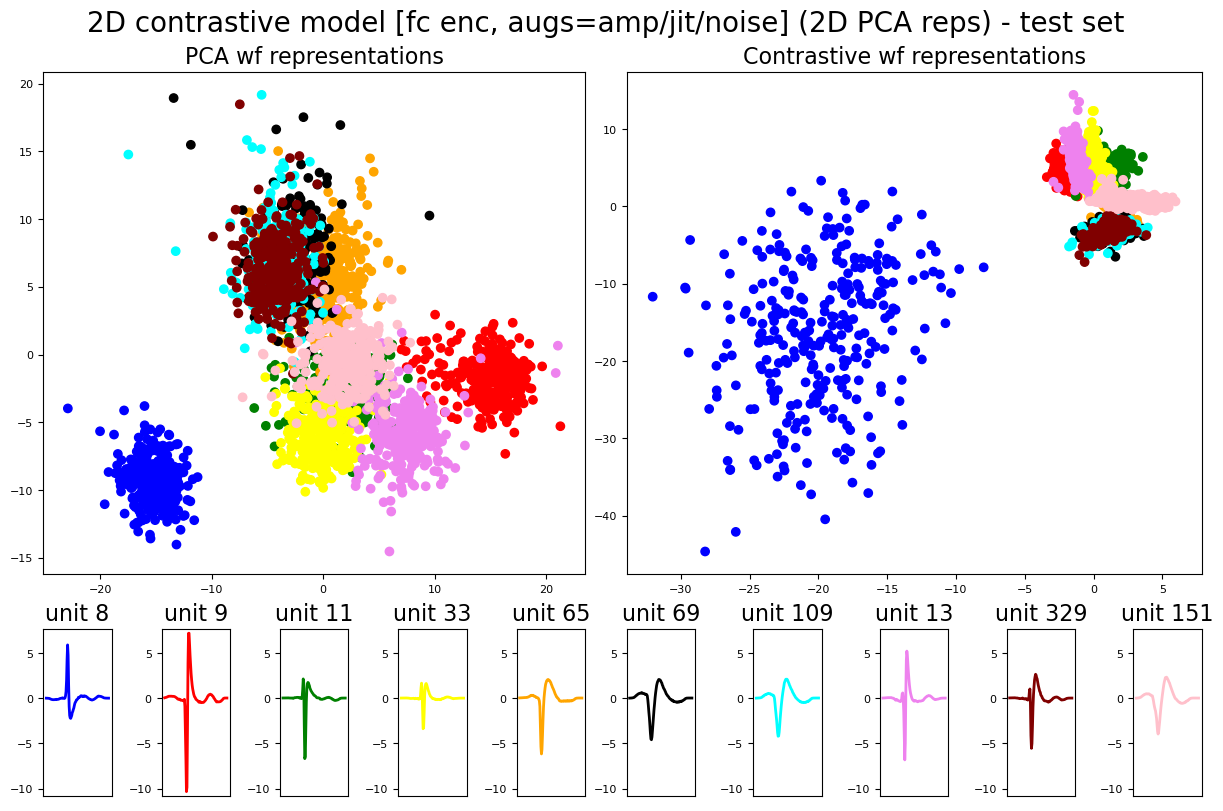

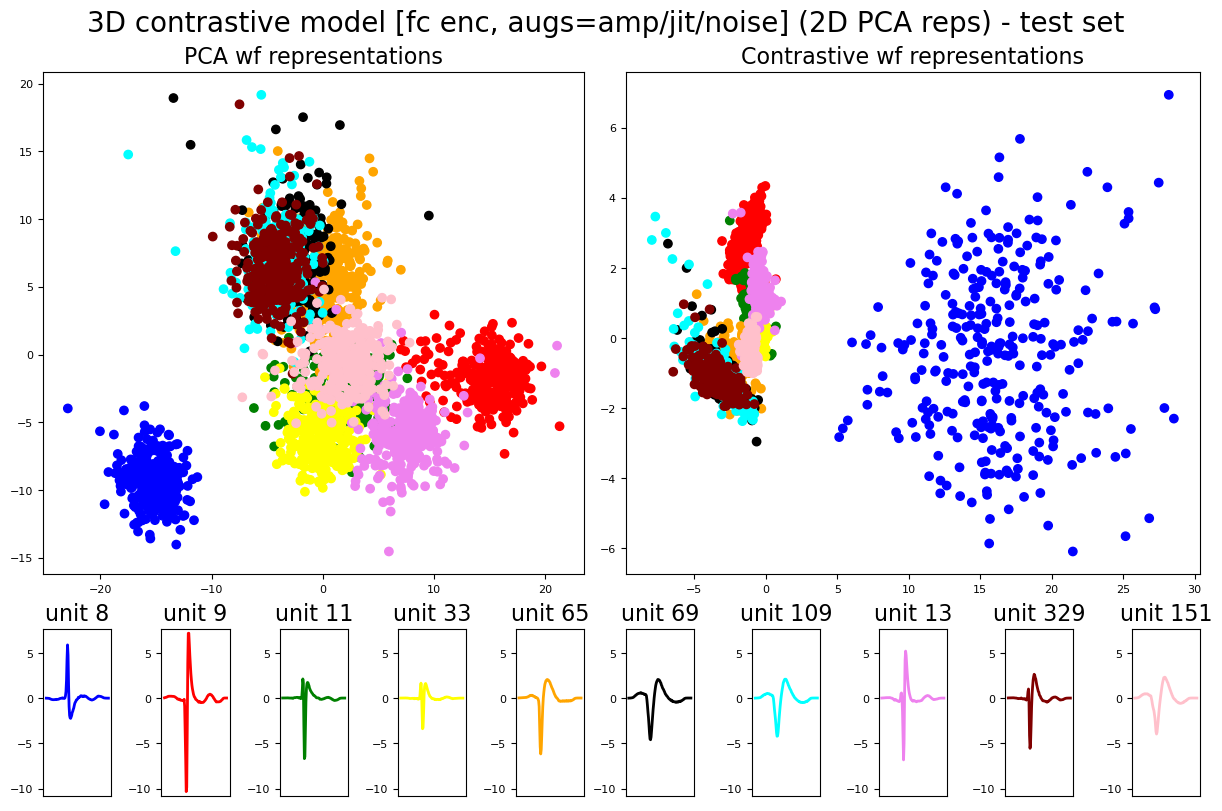

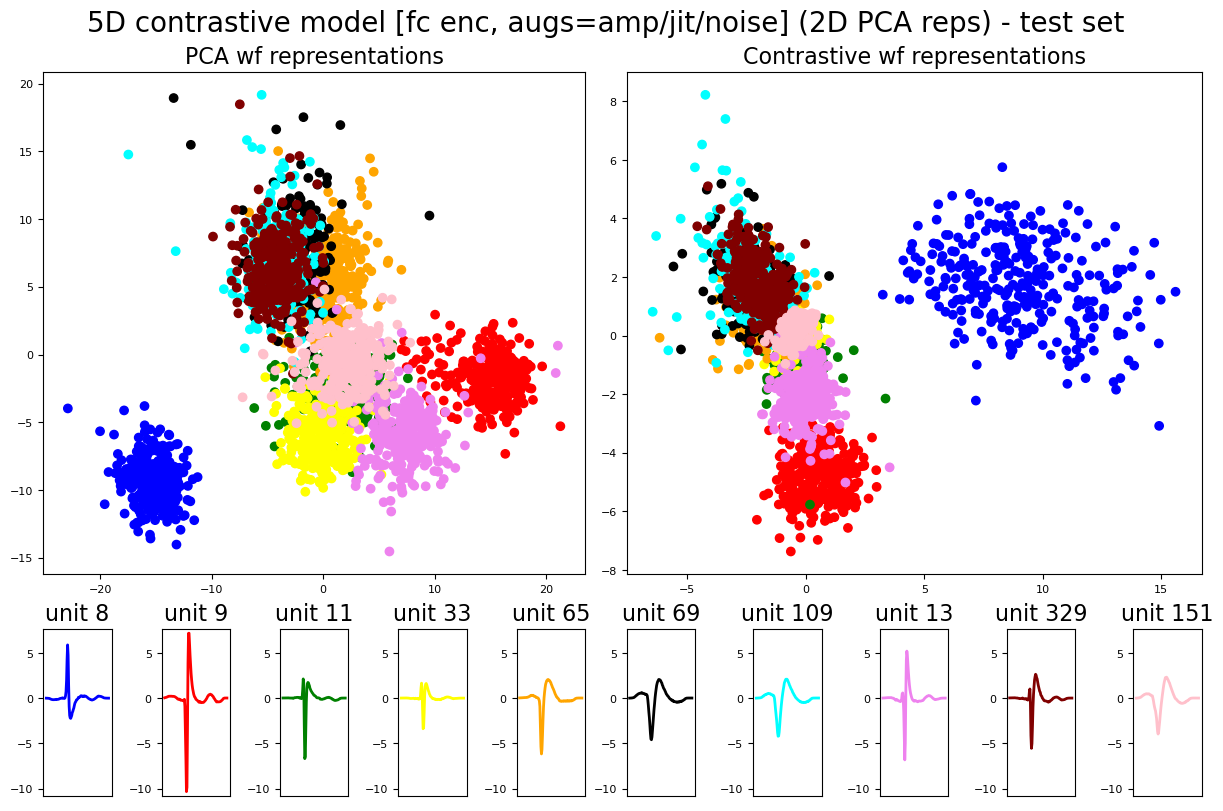

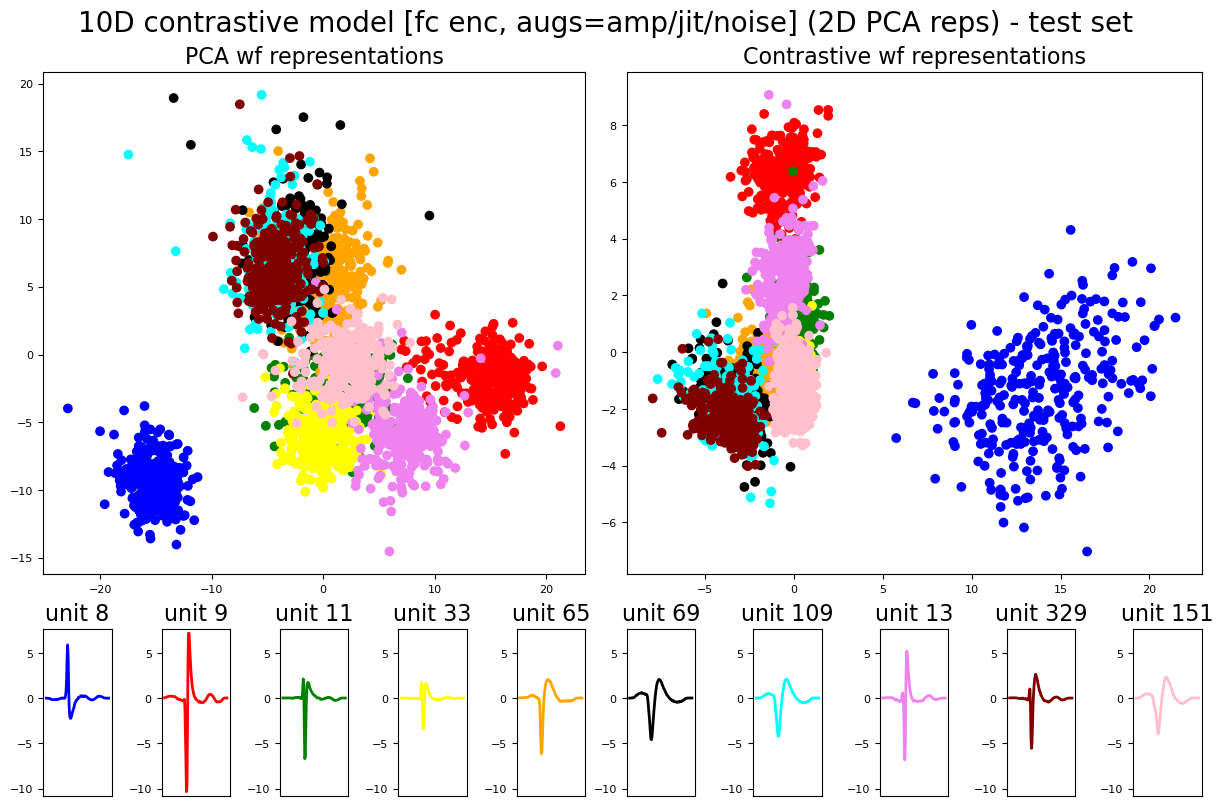

In [185]:
twod_norm_fcenc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-2d2d-normal-lr001/checkpoint_0400.pth.tar'
threed_norm_fcenc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-3d3d-normal-lr001/checkpoint_0400.pth.tar'
fived_norm_fcenc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-5d5d-normal/checkpoint_0500.pth.tar'
tend_norm_fcenc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-10d5d-normal-lr001/checkpoint_0400.pth.tar'


contr_reps_train_2d_n, contr_reps_test_2d_n, contr_reps_test_2d_pca_n, pca_train_2d, pca_test_2d = get_ckpt_results(twod_norm_fcenc_path, 2, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '2D contrastive model [fc enc, augs=amp/jit/noise] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_2dcont_normal_fcenc')
contr_reps_train_3d_n, contr_reps_test_3d_n, contr_reps_test_3d_pca_n, pca_train_3d, pca_test_3d = get_ckpt_results(threed_norm_fcenc_path, 3, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '3D contrastive model [fc enc, augs=amp/jit/noise] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_3dcont_normal_fcenc')
contr_reps_train_5d_n, contr_reps_test_5d_n, contr_reps_test_5d_pca_n, pca_train_5d, pca_test_5d = get_ckpt_results(fived_norm_fcenc_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '5D contrastive model [fc enc, augs=amp/jit/noise] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_5dcont_normal_fcenc')
contr_reps_train_10d_n, contr_reps_test_10d_n, contr_reps_test_10d_pca_n, pca_train_10d, pca_test_10d = get_ckpt_results(tend_norm_fcenc_path, 10, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '10D contrastive model [fc enc, augs=amp/jit/noise] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_10dcont_normal_fcenc')


train_reps = [pca_train_2d, pca_train_3d, pca_train_5d, pca_train_10d, 
              contr_reps_train_2d_n, contr_reps_train_3d_n, contr_reps_train_5d_n, 
              contr_reps_train_10d_n]
test_reps = [pca_test_2d, pca_test_3d, pca_test_5d, pca_test_10d,
             contr_reps_test_2d_n, contr_reps_test_3d_n, contr_reps_test_5d_n, 
             contr_reps_test_10d_n]
models = ['PCA 2D', 'PCA 3D', 'PCA 5D', 'PCA 10D',
          'Contrastive 2D (augs=amp/jit/noise, fc encoder)', 'Contrastive 3D (augs=amp/jit/noise, fc encoder)',
          'Contrastive 5D (augs=amp/jit/noise, fc encoder)', 'Contrastive 10D (augs=amp/jit/noise, fc encoder)']


per_class_map = per_class_accs(train_reps, test_reps, models, 10)
avg_class_map = avg_class_accs(train_reps, test_reps, models, 10)

pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)

In [58]:
train_reps = [pca_train_2d, pca_train_5d, pca_train_10d, pca_train_20d, contr_reps_train_2d, contr_reps_train_5d, contr_reps_train_10d, contr_reps_train_20d]
test_reps = [pca_test_2d, pca_test_5d, pca_test_10d, pca_test_20d, contr_reps_2d, contr_reps_5d, contr_reps_10d, contr_reps_20d]
models = ['PCA 2D', 'PCA 5D', 'PCA 10D', 'PCA 20D', 'Contrastive 2D (lr=0.001)', 'Contrastive 5D (lr=0.001)', 'Contrastive 10D (lr=0.001)', 'Contrastive 20D (lr=0.001)']

per_class_map = per_class_accs(train_reps, test_reps, models, 10)
avg_class_map = avg_class_accs(train_reps, test_reps, models, 10)

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
S

In [59]:
pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

In [60]:
# pd.set_option('display.max_rows', 10)
# display(pc_df)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)

wf 8       wf 9      wf 11      wf 33  \
PCA 2D                      100.000000  98.666667  48.666667  84.333333   
PCA 5D                      100.000000  99.333333  75.000000  92.666667   
PCA 10D                      99.666667  98.666667  82.666667  93.333333   
PCA 20D                     100.000000  95.000000  84.666667  93.000000   
Contrastive 2D (lr=0.001)    97.333333  86.000000  74.666667  62.333333   
Contrastive 5D (lr=0.001)   100.000000  95.666667  90.666667  86.666667   
Contrastive 10D (lr=0.001)  100.000000  94.333333  86.666667  79.666667   
Contrastive 20D (lr=0.001)  100.000000  92.666667  87.000000  82.666667   

                                wf 65      wf 69     wf 109      wf 13  \
PCA 2D                      75.000000  61.000000   0.000000  91.666667   
PCA 5D                      85.333333  42.000000  53.333333  91.000000   
PCA 10D                     90.666667  55.000000  50.666667  94.000000   
PCA 20D                     92.000000  51.333333  46.333333  94.333333   
Contrastive 2D (lr=0.001)   85.333333  43.666667  26.666667  74.666667   
Contrastive 5D (lr=0.001)   88.000000  59.333333  26.333333  78.666667   
Contrastive 10D (lr=0.001)  86.000000  60.000000  25.333333  79.000000   
Contrastive 20D (lr=0.001)  85.666667  44.000000  40.000000  86.000000   

                               wf 329     wf 151  
PCA 2D                      66.000000  70.333333  
PCA 5D                      50.333333  80.000000  
PCA 10D                     57.666667  85.000000  
PCA 20D                     69.000000  86.000000  
Contrastive 2D (lr=0.001)   49.000000  77.666667  
Contrastive 5D (lr=0.001)   69.333333  90.666667  
Contrastive 10D (lr=0.001)  62.666667  87.333333  
Contrastive 20D (lr=0.001)  62.333333  83.333333

In [61]:
# pd.set_option('display.max_rows', 10)
# display(pc_df)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)

PCA 2D     PCA 5D    PCA 10D  PCA 20D  Contrastive 2D (lr=0.001)  \
score  69.766667  76.966667  80.566667     81.0                       67.7   

       Contrastive 5D (lr=0.001)  Contrastive 10D (lr=0.001)  \
score                  77.933333                   76.033333   

       Contrastive 20D (lr=0.001)  
score                   76.866667

Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.


wf 8       wf 9      wf 11      wf 33  \
PCA 10D                     100.000000  97.333333  78.666667  93.000000   
PCA 20D                      99.666667  96.333333  85.333333  92.000000   
Contrastive 10D (lr=0.001)  100.000000  93.000000  89.666667  83.333333   
Contrastive 10D (lr=0.005)  100.000000  92.000000  86.666667  82.333333   
Contrastive 20D (lr=0.001)   99.666667  94.333333  90.333333  87.000000   

                                wf 65      wf 69     wf 109      wf 13  \
PCA 10D                     86.333333  58.000000  32.666667  94.666667   
PCA 20D                     90.333333  52.666667  58.666667  92.333333   
Contrastive 10D (lr=0.001)  89.333333  51.666667  29.000000  85.333333   
Contrastive 10D (lr=0.005)  78.666667  54.333333  23.000000  84.000000   
Contrastive 20D (lr=0.001)  85.666667  53.333333  41.666667  89.333333   

                               wf 329     wf 151  
PCA 10D                     69.333333  87.666667  
PCA 20D                     58.000000  83.333333  
Contrastive 10D (lr=0.001)  65.333333  88.000000  
Contrastive 10D (lr=0.005)  65.333333  82.333333  
Contrastive 20D (lr=0.001)  58.000000  86.333333

PCA 10D    PCA 20D  Contrastive 10D (lr=0.001)  \
score     80.7  80.766667                        77.1   

       Contrastive 10D (lr=0.005)  Contrastive 20D (lr=0.001)  
score                   74.433333                        78.4

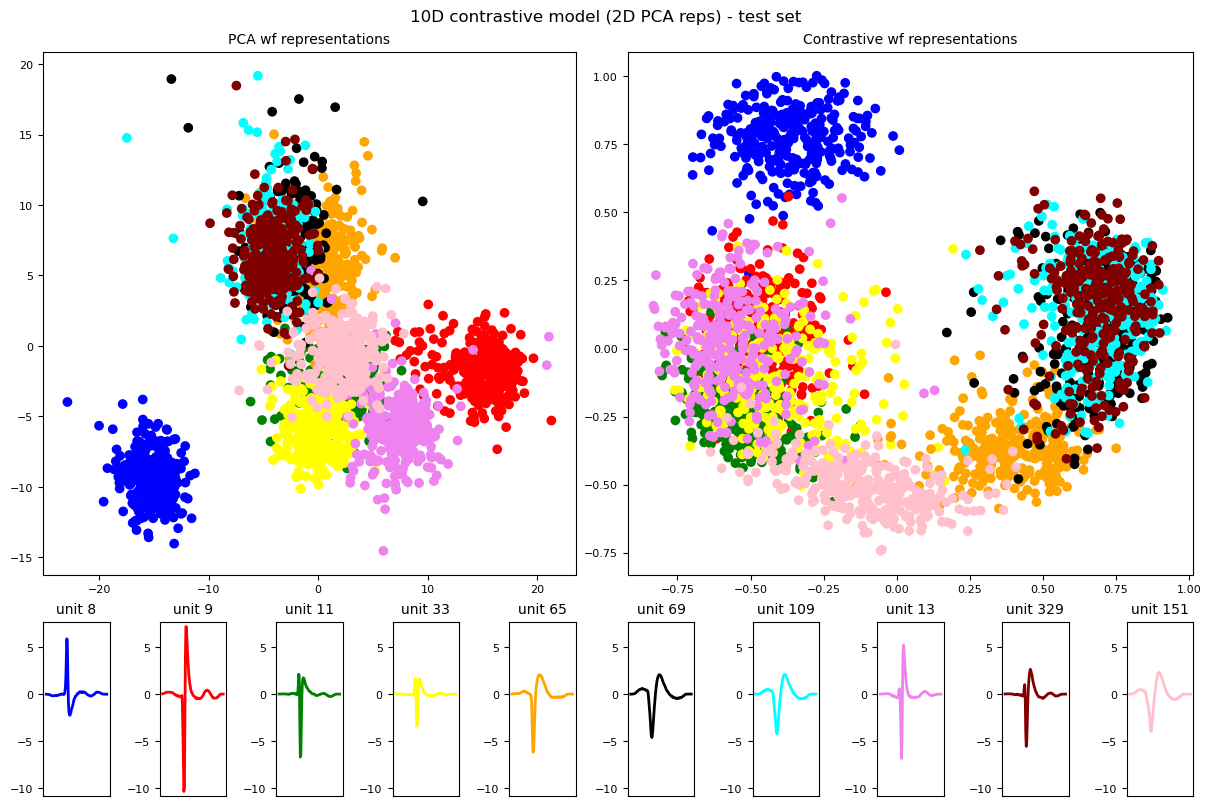

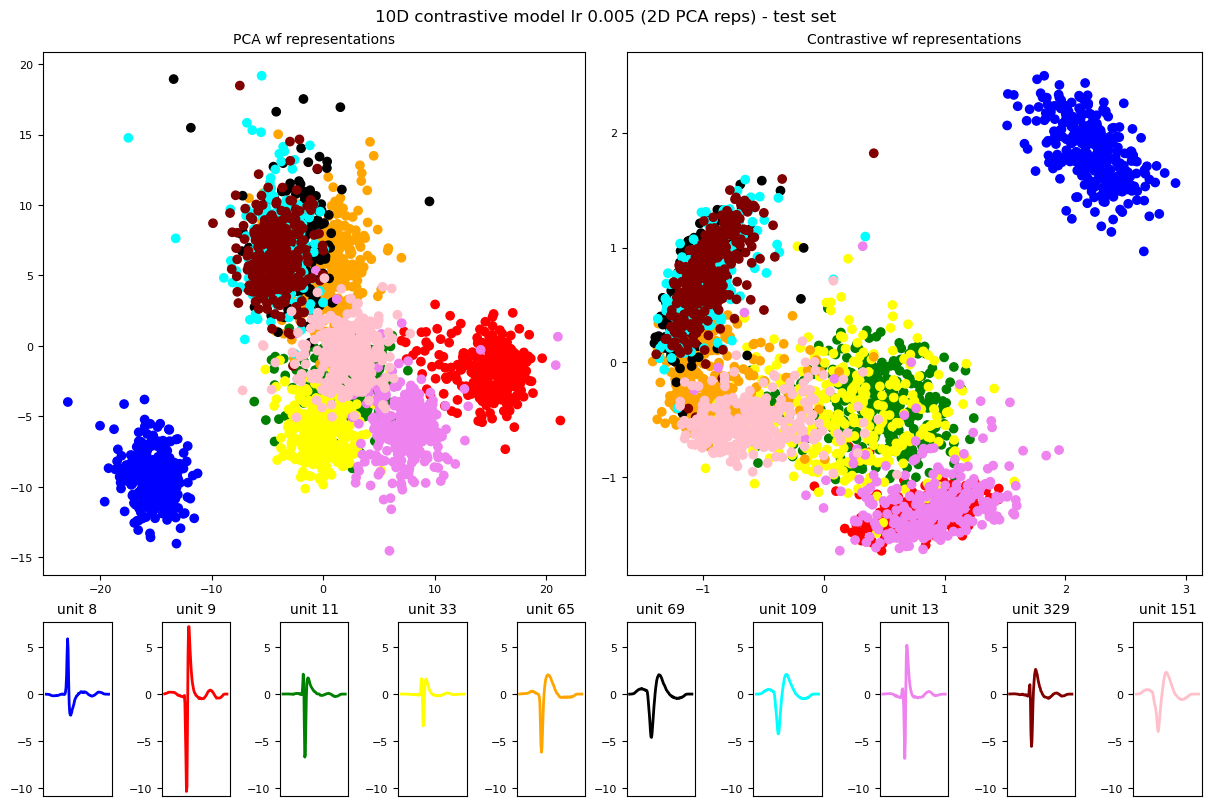

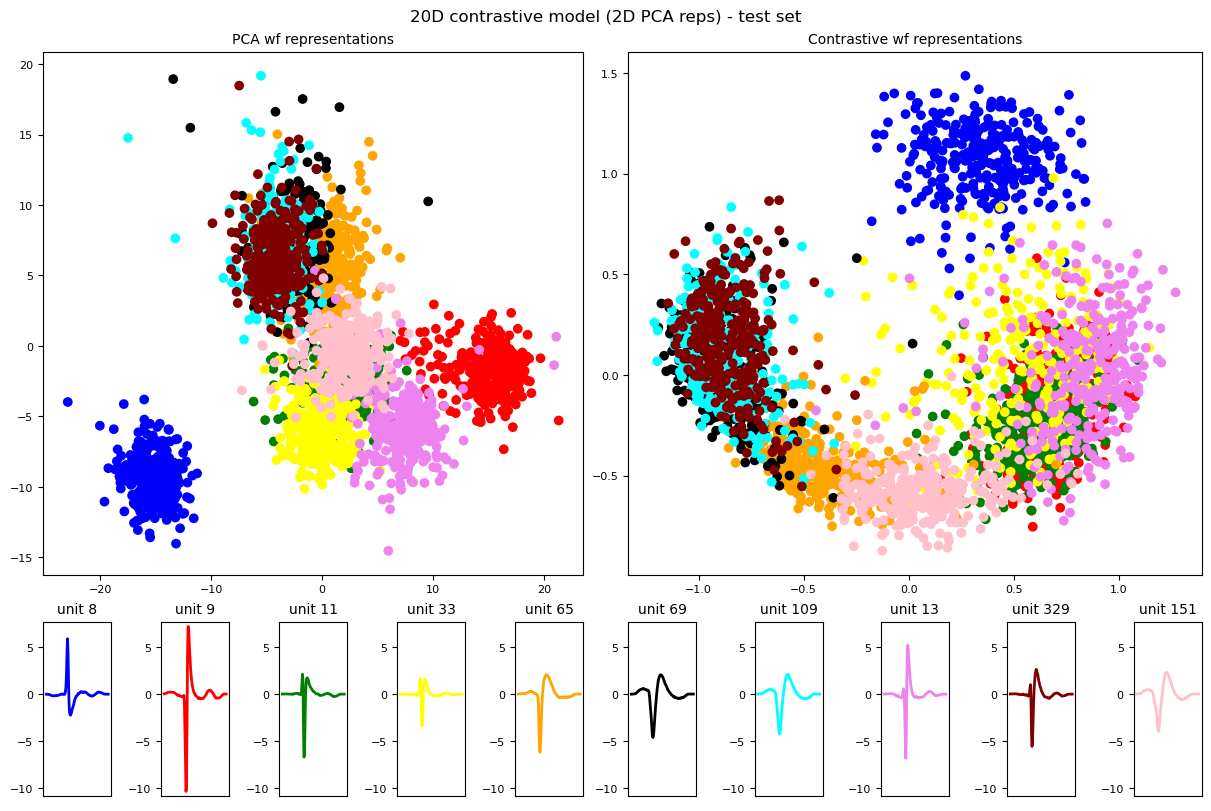

In [98]:
tend_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/proj_dim_5/enc-10d-pd-lr001/checkpoint_1000.pth.tar'
twentyd_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/proj_dim_5/enc-20d-pd-lr001/checkpoint_1000.pth.tar'
tend_lr_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/proj_dim_5/enc-10d-pd-lr005/checkpoint_1000.pth.tar'

contr_reps_train_10d, contr_reps_test_10d, contr_reps_test_10d_pca, pca_train_10d, pca_test_10d = get_ckpt_results(tend_enc_path, 10, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '10D contrastive model (2D PCA reps) - test set', save_name='pca_v_10dcont_pjlr001_sdv4')
contr_reps_train_10d_lr, contr_reps_test_10d_lr, contr_reps_test_10d_lr_pca, _, _ = get_ckpt_results(tend_lr_enc_path, 10, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '10D contrastive model lr 0.005 (2D PCA reps) - test set', save_name='pca_v_10dcont_pjlr005_sdv4')
contr_reps_train_20d, contr_reps_test_20d, contr_reps_test_20d_pca, pca_train_20d, pca_test_20d = get_ckpt_results(twentyd_enc_path, 20, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '20D contrastive model (2D PCA reps) - test set', save_name='pca_v_20dcont_pjlr001_sdv4')

train_reps = [pca_train_10d, pca_train_20d, contr_reps_train_10d, contr_reps_train_10d_lr, contr_reps_train_20d]
test_reps = [pca_test_10d, pca_test_20d, contr_reps_test_10d, contr_reps_test_10d_lr, contr_reps_test_20d]
models = ['PCA 10D', 'PCA 20D', 'Contrastive 10D (lr=0.001)', 'Contrastive 10D (lr=0.005)', 'Contrastive 20D (lr=0.001)']

per_class_map = per_class_accs(train_reps, test_reps, models, 10)
avg_class_map = avg_class_accs(train_reps, test_reps, models, 10)

pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)

Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.


wf 8       wf 9  \
PCA 10D                                         100.000000  99.000000   
PCA 20D                                         100.000000  96.333333   
Contrastive 10D (lr=0.001)                      100.000000  92.666667   
Contrastive 10D (lr=0.001, noise/collision on)  100.000000  96.666667   
Contrastive 20D (lr=0.001)                       99.666667  95.666667   

                                                    wf 11      wf 33  \
PCA 10D                                         80.333333  92.333333   
PCA 20D                                         82.000000  92.333333   
Contrastive 10D (lr=0.001)                      89.000000  84.000000   
Contrastive 10D (lr=0.001, noise/collision on)  89.666667  81.333333   
Contrastive 20D (lr=0.001)                      90.333333  84.000000   

                                                    wf 65      wf 69  \
PCA 10D                                         87.333333  53.000000   
PCA 20D                                         87.666667  39.333333   
Contrastive 10D (lr=0.001)                      89.333333  57.000000   
Contrastive 10D (lr=0.001, noise/collision on)  83.333333  27.000000   
Contrastive 20D (lr=0.001)                      85.333333  51.333333   

                                                   wf 109      wf 13  \
PCA 10D                                         52.000000  94.666667   
PCA 20D                                         51.666667  93.000000   
Contrastive 10D (lr=0.001)                      30.666667  85.000000   
Contrastive 10D (lr=0.001, noise/collision on)  48.000000  89.333333   
Contrastive 20D (lr=0.001)                      37.666667  88.000000   

                                                   wf 329     wf 151  
PCA 10D                                         62.000000  87.333333  
PCA 20D                                         54.666667  85.666667  
Contrastive 10D (lr=0.001)                      57.333333  87.666667  
Contrastive 10D (lr=0.001, noise/collision on)  69.333333  88.333333  
Contrastive 20D (lr=0.001)                      65.333333  90.666667

PCA 10D    PCA 20D  Contrastive 10D (lr=0.001)  \
score  80.133333  77.733333                   77.366667   

       Contrastive 10D (lr=0.001, noise/collision on)  \
score                                       77.133333   

       Contrastive 20D (lr=0.001)  
score                   78.766667

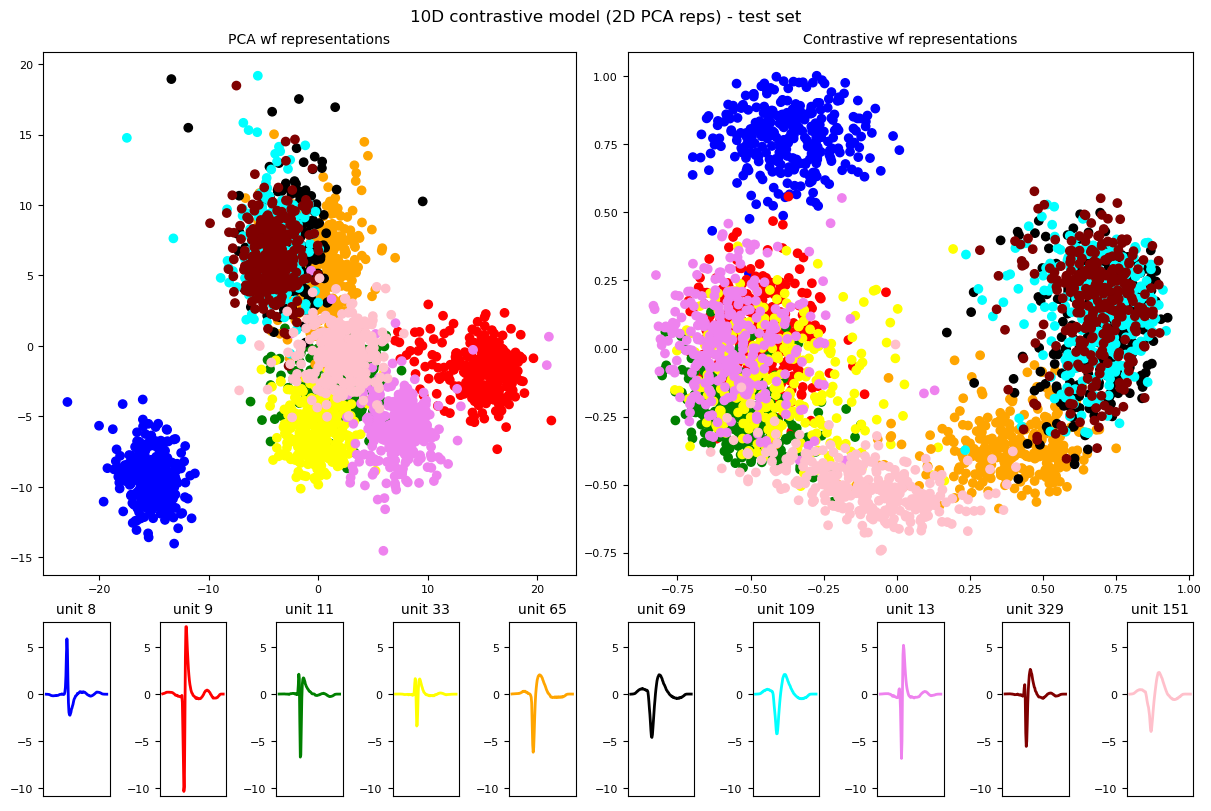

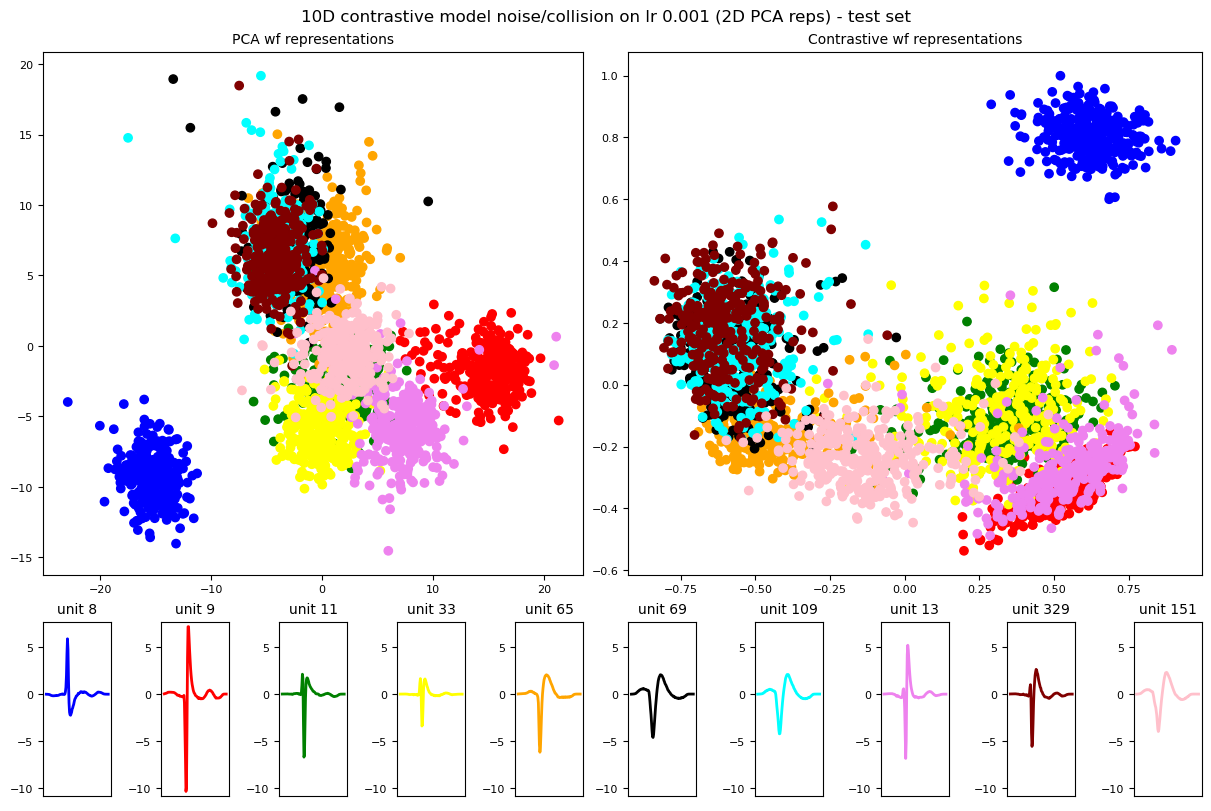

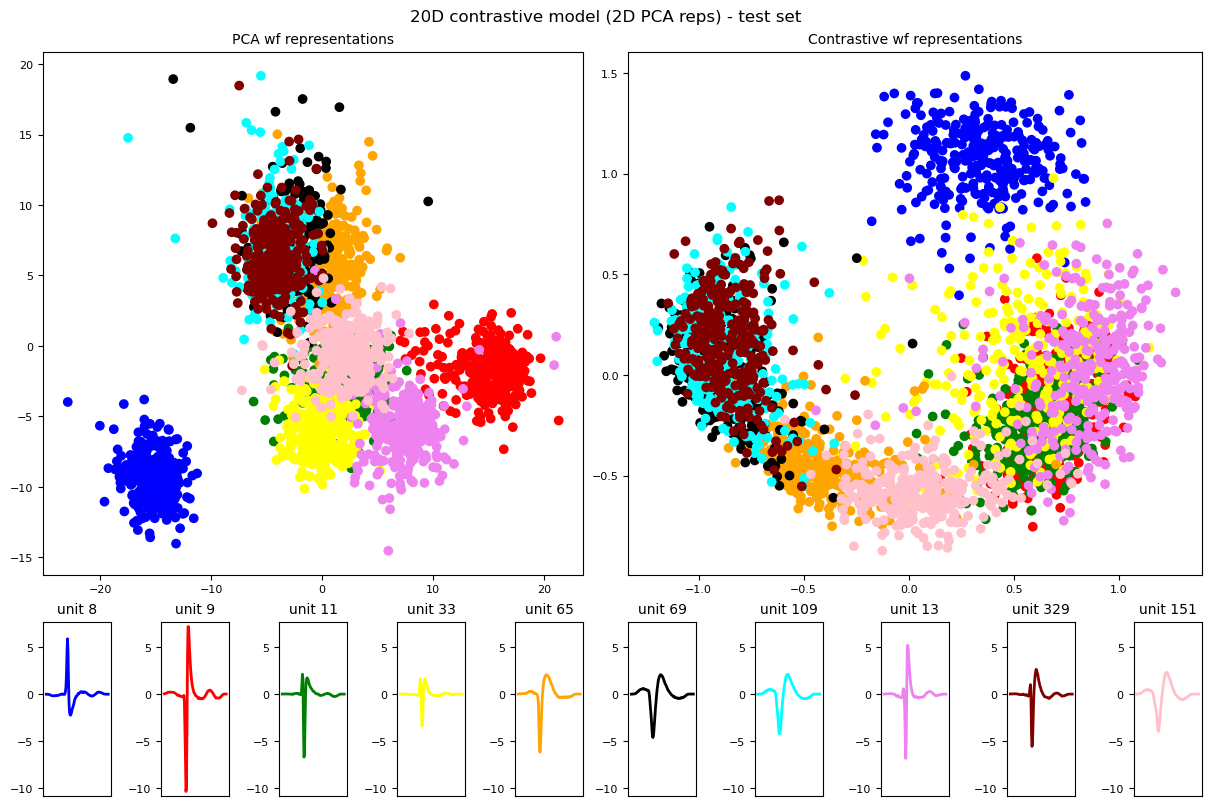

In [51]:
tend_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/proj_dim_5/enc-10d-pd-lr001/checkpoint_1000.pth.tar'
twentyd_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/proj_dim_5/enc-20d-pd-lr001/checkpoint_1000.pth.tar'
tend_na_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/enc-10d-lr001/checkpoint_1000.pth.tar'

contr_reps_train_10d, contr_reps_test_10d, contr_reps_test_10d_pca, pca_train_10d, pca_test_10d = get_ckpt_results(tend_enc_path, 10, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '10D contrastive model (2D PCA reps) - test set', save_name='pca_v_10dcont_pjlr001_sdv4')
contr_reps_train_10d_na, contr_reps_test_10d_na, contr_reps_test_10d_na_pca, _, _ = get_ckpt_results(tend_na_enc_path, 10, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '10D contrastive model noise/collision on lr 0.001 (2D PCA reps) - test set', save_name='pca_v_10dcont_pjlr005_ua_sdv4')
contr_reps_train_20d, contr_reps_test_20d, contr_reps_test_20d_pca, pca_train_20d, pca_test_20d = get_ckpt_results(twentyd_enc_path, 20, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '20D contrastive model (2D PCA reps) - test set', save_name='pca_v_20dcont_pjlr001_sdv4')

train_reps = [pca_train_10d, pca_train_20d, contr_reps_train_10d, contr_reps_train_10d_na, contr_reps_train_20d]
test_reps = [pca_test_10d, pca_test_20d, contr_reps_test_10d, contr_reps_test_10d_na, contr_reps_test_20d]
models = ['PCA 10D', 'PCA 20D', 'Contrastive 10D (lr=0.001)', 'Contrastive 10D (lr=0.001, noise/collision on)', 'Contrastive 20D (lr=0.001)']

per_class_map = per_class_accs(train_reps, test_reps, models, 10)
avg_class_map = avg_class_accs(train_reps, test_reps, models, 10)

pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)